# DeconvNet Model Comparison Notebook  
This notebook compares multiple DeconvNet models by loading their saved architectures and evaluating them on the same test dataset.  

**Features:**  
- Loads models from saved `architecture.py` files for comparison of model iterations
- Generates comprehensive comparison plots
- Uses centralized output management system
- Compares against GalSim deconvolution baseline

**Requirements:**  
- `plots/[model_name]/architecture.py` should contain the model class (done automatically)
- Model checkpoints should be in: `model_checkpoint/[model_name]/` (done automatically)
- Loss files should be in: `plots/[model_name]/[model_name]_loss.npz` (done automatically)

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import jax.random as random
import jax.numpy as jnp
import numpy as np
import optax
import os
from dataclasses import dataclass
from typing import List, Optional, Dict, Any, Tuple
import sys
import importlib.util
import re

from shearnet.core.dataset import generate_dataset, split_combined_images
from shearnet.config.config_handler import Config

from flax.training import checkpoints, train_state

from shearnet.deconvnet.utils.metrics import (
    eval_model, eval_galsim_deconv, calculate_psnr, 
    calculate_ssim, normalize_data, inverse_normalized_data
)

from shearnet.deconvnet.utils.plot_helpers import (
    plot_comparison, plot_spatial_residuals
)

from shearnet.utils.notebook_output_system import (
    log_print, save_plot, log_array_stats, experiment_section, get_output_manager
)

In [2]:
@dataclass
class DeconvNetModelConfig:
    """Configuration for a DeconvNet model to compare"""
    name: str  # Display name for plots
    model_dir_prefix: str  # Directory prefix to search for
    color: str  # Color for plots
    marker: str = 'o'  # Marker style for scatter plots
    
    def __post_init__(self):
        """Initialize configuration containers"""
        self.training_config = None
        self.test_config = None

@dataclass 
class GalSimDeconvConfig:
    """Configuration for GalSim deconvolution comparison"""
    # Display properties
    name: str = "GalSim Deconvolution"
    color: str = 'green'
    marker: str = '^'
    
    # Dataset generation parameters
    samples: int = 5000
    psf_sigma: float = 0.25
    nse_sd: float = 1e-2
    exp: str = 'superbit'
    seed: int = 42
    stamp_size: int = 53
    pixel_size: float = 0.141
    
    # PSF shear parameters
    apply_psf_shear: bool = False
    psf_shear_range: float = 0.05
    
    # Processing parameters
    n_jobs: int = 1  # Number of parallel jobs (1 to avoid JAX conflicts)

def load_model_training_config(model_config: DeconvNetModelConfig, base_data_path: str) -> Config:
    """Load the training configuration for a model"""
    config_path = os.path.join(base_data_path, "plots", model_config.model_dir_prefix, 'training_config.yaml')
    
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"No training config found at {config_path}")
    
    log_print(f"Loading training config for {model_config.name}: {config_path}")
    config = Config(config_path)
    model_config.training_config = config
    
    # Extract test configuration parameters
    model_config.test_config = {
        'samples': config.get('evaluation.test_samples', 5000),
        'psf_sigma': config.get('dataset.psf_sigma'),
        'nse_sd': config.get('dataset.nse_sd'),
        'normalized': config.get('dataset.normalized', False),
        'exp': config.get('dataset.exp'),
        'seed': config.get('evaluation.seed', config.get('dataset.seed')),
        'stamp_size': config.get('dataset.stamp_size'),
        'pixel_size': config.get('dataset.pixel_size'),
        'apply_psf_shear': config.get('dataset.apply_psf_shear', False),
        'psf_shear_range': config.get('dataset.psf_shear_range', 0.05),
        'model_type': config.get('deconv.model_type')
    }
    
    return config

def generate_test_data_for_model(model_config: DeconvNetModelConfig) -> Tuple[np.ndarray, np.ndarray, np.ndarray, List]:
    """Generate test data based on model's training configuration"""
    config = model_config.test_config
    
    log_print(f"Generating test data for {model_config.name}:")
    log_print(f"  Samples: {config['samples']}")
    log_print(f"  PSF sigma: {config['psf_sigma']}")
    log_print(f"  Noise SD: {config['nse_sd']}")
    log_print(f"  Normalized: {config['normalized']}")
    log_print(f"  Experiment: {config['exp']}")
    log_print(f"  Stamp size: {config['stamp_size']}")
    log_print(f"  Pixel size: {config['pixel_size']}")
    log_print(f"  PSF shear: {config['apply_psf_shear']}")
    
    # Generate test dataset with clean images and PSF
    combined_images, labels, obs = generate_dataset(
        config['samples'], config['psf_sigma'], npix=config['stamp_size'], 
        scale=config['pixel_size'], type='gauss', exp=config['exp'], 
        nse_sd=config['nse_sd'], seed=config['seed'], 
        return_clean=True, return_psf=True, return_obs=True,
        apply_psf_shear=config['apply_psf_shear'], 
        psf_shear_range=config['psf_shear_range']
    )
    
    # Split into galaxy, PSF, and clean (target) images
    galaxy_images, psf_images, clean_images = split_combined_images(
        combined_images, has_psf=True, has_clean=True
    )
    
    return galaxy_images, psf_images, clean_images, obs

def load_model_from_architecture(model_config: DeconvNetModelConfig, base_checkpoint_path: str, 
                                base_data_path: str):
    """Load a DeconvNet model using its saved architecture.py file and evaluate it"""
    # Load training configuration first
    training_config = load_model_training_config(model_config, base_data_path)
    
    # Generate test data based on model's specific training configuration
    galaxy_images, psf_images, clean_images, obs = generate_test_data_for_model(model_config)
    
    # Normalize if needed
    means, stds = None, None
    if model_config.test_config['normalized']:
        (galaxy_images, psf_images, clean_images), (means, stds) = normalize_data(
            galaxy_images, psf_images, clean_images
        )
    
    # Path to the saved architecture file
    arch_file = os.path.join(base_data_path, "plots", model_config.model_dir_prefix, "architecture.py")

    if not os.path.exists(arch_file):
        raise FileNotFoundError(f"Architecture file not found: {arch_file}")

    log_print(f"Loading architecture from: {arch_file}")

    model_type = model_config.test_config['model_type']
    log_print(f"Model type: {model_type}")
    
    # Dynamically import the architecture module
    spec = importlib.util.spec_from_file_location(f"{model_config.model_dir_prefix}_arch", arch_file)
    arch_module = importlib.util.module_from_spec(spec)
    sys.modules[f"{model_config.model_dir_prefix}_arch"] = arch_module
    spec.loader.exec_module(arch_module)

    # Get the appropriate model class from the loaded architecture
    if model_type == "base":
        model = arch_module.PSFDeconvolutionNet()
    elif model_type == "enhanced":
        model = arch_module.EnhancedPSFDeconvNet()
    elif model_type == "research_backed":
        model = arch_module.ResearchBackedPSFDeconvolutionUNet()
    else:
        raise ValueError(f"Invalid model type specified: {model_type}")

    log_print(f"Successfully loaded model: {type(model).__name__}")

    # Initialize model parameters
    rng_key = random.PRNGKey(model_config.test_config['seed'])
    init_params = model.init(
        rng_key, 
        jnp.ones_like(galaxy_images[0][..., None]), 
        jnp.ones_like(psf_images[0][..., None]),
        deterministic=True
    )
    
    state = train_state.TrainState.create(
        apply_fn=model.apply, params=init_params, tx=optax.adam(1e-3)
    )
    
    # Find matching checkpoint directory
    prefix = re.escape(model_config.model_dir_prefix)
    pattern = f"^{prefix}(?:[0-9]|$)"

    all_dirs = [
        d for d in os.listdir(base_checkpoint_path) 
        if os.path.isdir(os.path.join(base_checkpoint_path, d))
    ]

    matching_dirs = [
        d for d in all_dirs
        if re.match(pattern, d)
    ]

    log_print(f"Found {len(matching_dirs)} matching directories for {model_config.name}: {matching_dirs}")
    
    if not matching_dirs:
        raise FileNotFoundError(f"No directory found for {model_config.name} with prefix: {model_config.model_dir_prefix}")
    
    # Use the latest directory if multiple found
    model_dir = os.path.join(base_checkpoint_path, sorted(matching_dirs)[-1])
    log_print(f"Loading {model_config.name} from: {model_dir}")
    
    # Restore checkpoint
    state = checkpoints.restore_checkpoint(ckpt_dir=model_dir, target=state)
    log_print("Model checkpoint loaded successfully.")
    
    # Evaluate the model
    if model_config.test_config['normalized']:
        results = eval_model(
            state, galaxy_images, psf_images, clean_images, 
            means, stds, normalized=True
        )
    else:
        results = eval_model(
            state, galaxy_images, psf_images, clean_images, 
            normalized=False
        )
    
    return {
        'predictions': results['predictions'],
        'config': model_config,
        'results': results,
        'type': 'deconvnet',
        'galaxy_images': galaxy_images,
        'psf_images': psf_images,
        'target_images': clean_images,
        'observations': obs,
        'test_config': model_config.test_config
    }, training_config

def evaluate_galsim_deconv(galsim_config: GalSimDeconvConfig):
    """Evaluate GalSim deconvolution with specific configuration"""
    log_print(f"Generating test data for {galsim_config.name}:")
    log_print(f"  Samples: {galsim_config.samples}")
    log_print(f"  PSF σ: {galsim_config.psf_sigma}")
    log_print(f"  Noise SD: {galsim_config.nse_sd:.1e}")
    log_print(f"  Experiment: {galsim_config.exp}")
    log_print(f"  PSF shear: {galsim_config.apply_psf_shear}")
    
    # Generate test data
    combined_images, labels, obs = generate_dataset(
        galsim_config.samples, 
        galsim_config.psf_sigma, 
        npix=galsim_config.stamp_size, 
        scale=galsim_config.pixel_size,
        type='gauss',
        exp=galsim_config.exp, 
        nse_sd=galsim_config.nse_sd, 
        seed=galsim_config.seed, 
        return_clean=True,
        return_psf=True,
        return_obs=True,
        apply_psf_shear=galsim_config.apply_psf_shear,
        psf_shear_range=galsim_config.psf_shear_range
    )
    
    # Split into separate arrays
    galaxy_images, psf_images, clean_images = split_combined_images(
        combined_images, has_psf=True, has_clean=True
    )
    
    # Evaluate GalSim deconvolution
    log_print(f"Evaluating {galsim_config.name}...")
    results = eval_galsim_deconv(
        observations=obs,
        target_images=clean_images,
        n_jobs=galsim_config.n_jobs
    )
    
    return {
        'predictions': results['predictions'],
        'config': galsim_config,
        'results': results,
        'type': 'galsim',
        'galaxy_images': galaxy_images,
        'psf_images': psf_images,
        'target_images': clean_images,
        'observations': obs,
        'test_config': {
            'samples': galsim_config.samples,
            'psf_sigma': galsim_config.psf_sigma,
            'nse_sd': galsim_config.nse_sd,
            'exp': galsim_config.exp,
            'apply_psf_shear': galsim_config.apply_psf_shear,
            'psf_shear_range': galsim_config.psf_shear_range
        }
    }

## Configuration  
Modify this section to set up your comparison:

In [3]:
# ==============================================================================
# CONFIGURATION: MODIFY THIS TO SET UP YOUR COMPARISON
# ==============================================================================

# Define the DeconvNet models you want to compare
model_configs = [
    DeconvNetModelConfig(
        name="Research-Backed (Normalized, Low Noise)",
        model_dir_prefix="research_backed_ideal_normalized_low-noise",
        color="blue", 
        marker="s"
    ),
    DeconvNetModelConfig(
        name="Research-Backed (Not Normalized, Low Noise)",
        model_dir_prefix="research_backed_ideal_not-normalized_low-noise",
        color="red", 
        marker="o"
    ),
    # Add more models here...
]

# Define GalSim deconvolution configurations
# Set to empty list [] if you don't want GalSim comparison
galsim_configs = [
    # GalSimDeconvConfig(
    #     name="GalSim Deconvolution",
    #     color="green",
    #     marker="^",
    #     samples=5000,
    #     psf_sigma=0.25,
    #     nse_sd=1e-5,
    #     exp='ideal',
    #     seed=42,
    #     n_jobs=1  # Keep at 1 to avoid JAX multiprocessing conflicts
    # ),
]

# To disable GalSim comparisons entirely, use:
# galsim_configs = []

# Print configuration
log_print("="*60)
log_print("DECONVNET COMPARISON CONFIGURATION", level="HEADER")
log_print("="*60)
log_print(f"DeconvNet models to compare: {[config.name for config in model_configs]}")
log_print(f"GalSim configs to compare: {[config.name for config in galsim_configs] if galsim_configs else 'NO GALSIM'}")
log_print(f"Total methods to evaluate: {len(model_configs) + len(galsim_configs)}")
log_print("="*60)

DEBUG: Current working directory: /home/adfield/ShearNet/notebooks
DEBUG: Found 'notebooks' in current path
DEBUG: Attempting to create directory: /home/adfield/ShearNet/notebooks/out
DEBUG: Directory created/exists: /home/adfield/ShearNet/notebooks/out
DEBUG: Directory is writable: True
DEBUG: Created new output file: /home/adfield/ShearNet/notebooks/out/out.md
ShearNet Output Manager initialized:
  Output directory: /home/adfield/ShearNet/notebooks/out
  Output file: /home/adfield/ShearNet/notebooks/out/out.md
  Directory exists: True
  Can write to directory: True
DECONVNET COMPARISON CONFIGURATION
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
DeconvNet models to compare: ['Research-Backed (Normalized, Low Noise)', 'Research-Backed (Not Normalized, Low Noise)']
GalSim configs to compare: NO GALSIM
Total methods to evaluate: 2


## Test Dataset Generation

In [4]:
with experiment_section("Test Dataset Generation"):
    base_data_path = os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.'))
    
    # Default test dataset parameters (for plotting consistency)
    test_samples = 5000
    test_seed = 42
    
    rng_key = random.PRNGKey(test_seed)

    # Generate shared test dataset
    combined_test_images, test_labels, test_obs = generate_dataset(
        test_samples, 0.25, npix=53, scale=0.141, type='gauss', exp='ideal', 
        nse_sd=1e-5, seed=test_seed, return_clean=True, return_psf=True, return_obs=True
    )
    
    # Split into separate arrays
    test_galaxy_images, test_psf_images, test_target_images = split_combined_images(
        combined_test_images, has_psf=True, has_clean=True
    )
    
    log_print(f"Generated {len(test_galaxy_images)} shared test samples for plotting")
    log_print(f"Galaxy image shape: {test_galaxy_images.shape}")
    log_print(f"PSF image shape: {test_psf_images.shape}")
    log_print(f"Target image shape: {test_target_images.shape}")
    
    # Log array statistics
    log_array_stats("test_galaxy_images", test_galaxy_images)
    log_array_stats("test_psf_images", test_psf_images)
    log_array_stats("test_target_images", test_target_images)

Test Dataset Generation
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md


100%|██████████| 5000/5000 [00:09<00:00, 543.20it/s]


Generated 5000 shared test samples for plotting
Galaxy image shape: (5000, 53, 53)
PSF image shape: (5000, 53, 53)
Target image shape: (5000, 53, 53)
test_galaxy_images stats: shape=(5000, 53, 53), min=-0.000, max=0.174, mean=0.001, std=0.005
test_psf_images stats: shape=(5000, 53, 53), min=-0.000, max=0.049, mean=0.000, std=0.003
test_target_images stats: shape=(5000, 53, 53), min=-0.000, max=0.663, mean=0.001, std=0.007
---


## Learning Curves Comparison

Learning Curves Comparison
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
Research-Backed (Normalized, Low Noise) training stats:
  Final training loss: 0.000420
  Final validation loss: 0.000905
  Best validation loss: 0.000217 at epoch 19
  Total epochs: 44
Research-Backed (Not Normalized, Low Noise) training stats:
  Final training loss: 0.000000
  Final validation loss: 0.000000
  Best validation loss: 0.000000 at epoch 19
  Total epochs: 44
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/deconvnet_learning_curves_comparison_20251005_230135.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/deconvnet_learning_curves_comparison_20251005_230135.png (size: 351283 bytes)
![deconvnet_learning_curves_comparison_20251005_230135.png](deconvnet_learning_curves_comparison_20251005_230135.png)


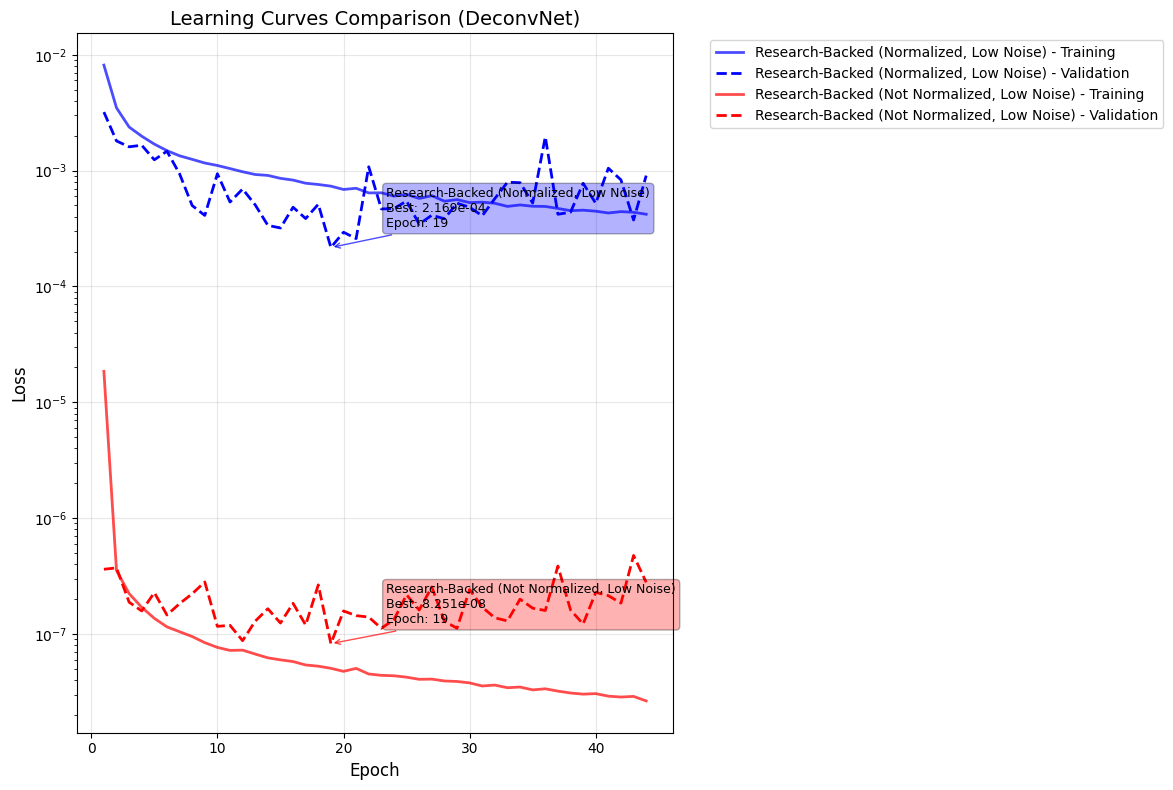

---


In [5]:
with experiment_section("Learning Curves Comparison"):
    base_data_path = os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.'))
    
    plt.figure(figsize=(12, 8))
    
    for config in model_configs:
        # Load loss data for this model
        loss_file = os.path.join(base_data_path, "plots", config.model_dir_prefix, f"{config.model_dir_prefix}_loss.npz")
        
        if os.path.exists(loss_file):
            loss = np.load(loss_file)
            train_loss = loss['train_loss']
            val_loss = loss['val_loss']
            
            epochs = np.arange(1, len(train_loss) + 1)
            
            # Plot with model-specific colors
            plt.plot(epochs, train_loss, color=config.color, linestyle='-', 
                    label=f'{config.name} - Training', linewidth=2, alpha=0.7)
            plt.plot(epochs, val_loss, color=config.color, linestyle='--', 
                    label=f'{config.name} - Validation', linewidth=2)
            
            # Add annotations for best validation loss
            best_val_epoch = np.argmin(val_loss) + 1
            best_val_loss = np.min(val_loss)
            plt.annotate(f'{config.name}\nBest: {best_val_loss:.3e}\nEpoch: {best_val_epoch}',
                        xy=(best_val_epoch, best_val_loss), 
                        xytext=(best_val_epoch + len(epochs)*0.1, best_val_loss * 1.5),
                        arrowprops=dict(arrowstyle='->', color=config.color, alpha=0.7),
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=config.color, alpha=0.3))
            
            # Log statistics
            log_print(f"{config.name} training stats:")
            log_print(f"  Final training loss: {train_loss[-1]:.6f}")
            log_print(f"  Final validation loss: {val_loss[-1]:.6f}") 
            log_print(f"  Best validation loss: {best_val_loss:.6f} at epoch {best_val_epoch}")
            log_print(f"  Total epochs: {len(train_loss)}")
        else:
            log_print(f"Warning: Loss file not found for {config.name}: {loss_file}")

    plt.yscale("log")
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Learning Curves Comparison (DeconvNet)', fontsize=14)
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    save_plot("deconvnet_learning_curves_comparison.png")
    plt.show()

## Model Loading and Evaluation

In [6]:
with experiment_section("Model Loading and Evaluation"):
    base_checkpoint_path = os.path.join(base_data_path, "model_checkpoint")
    
    # Dictionary to store all results
    all_results = {}
    all_configs = {}
    
    # Evaluate each DeconvNet model
    for model_config in model_configs:
        log_print(f"\nEvaluating {model_config.name}...", level="SUBHEADER")
        try:
            results, config = load_model_from_architecture(
                model_config, base_checkpoint_path, base_data_path
            )
            all_results[model_config.name] = results
            all_configs[model_config.name] = config
            log_print(f"Successfully evaluated {model_config.name}")
            log_print(f"  MSE: {results['results']['mse']:.3e}")
            log_print(f"  PSNR: {results['results']['psnr']:.2f} dB")
            log_print(f"  SSIM: {results['results']['ssim']:.4f}")
        except Exception as e:
            log_print(f"Failed to evaluate {model_config.name}: {str(e)}")
            continue

    # Evaluate each GalSim configuration
    if galsim_configs:
        log_print(f"\nEvaluating {len(galsim_configs)} GalSim configurations...", level="SUBHEADER")
        for galsim_config in galsim_configs:
            log_print(f"\nEvaluating {galsim_config.name}...", level="SUBHEADER")
            try:
                results = evaluate_galsim_deconv(galsim_config)
                all_results[galsim_config.name] = results
                log_print(f"Successfully evaluated {galsim_config.name}")
                log_print(f"  MSE: {results['results']['mse']:.3e}")
                log_print(f"  PSNR: {results['results']['psnr']:.2f} dB")
                log_print(f"  SSIM: {results['results']['ssim']:.4f}")
            except Exception as e:
                log_print(f"Failed to evaluate {galsim_config.name}: {str(e)}")
                continue
    else:
        log_print("\nNo GalSim configurations to evaluate.", level="SUBHEADER")

    log_print(f"\nAll evaluations complete! Methods: {list(all_results.keys())}")

Model Loading and Evaluation
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md

Evaluating Research-Backed (Normalized, Low Noise)...
Loading training config for Research-Backed (Normalized, Low Noise): /home/adfield/ShearNet/plots/research_backed_ideal_normalized_low-noise/training_config.yaml
Generating test data for Research-Backed (Normalized, Low Noise):
  Samples: 5000
  PSF sigma: 0.25
  Noise SD: 1e-05
  Normalized: True
  Experiment: ideal
  Stamp size: 53
  Pixel size: 0.141
  PSF shear: True


100%|██████████| 5000/5000 [00:06<00:00, 744.83it/s]


Loading architecture from: /home/adfield/ShearNet/plots/research_backed_ideal_normalized_low-noise/architecture.py
Model type: research_backed
Successfully loaded model: ResearchBackedPSFDeconvolutionUNet
Found 1 matching directories for Research-Backed (Normalized, Low Noise): ['research_backed_ideal_normalized_low-noise44']
Loading Research-Backed (Normalized, Low Noise) from: /home/adfield/ShearNet/model_checkpoint/research_backed_ideal_normalized_low-noise44
Model checkpoint loaded successfully.
Compiling evaluation function...
Compilation complete. Running evaluation...

=== Neural Deconvolution Results ===
Mean Squared Error (MSE): 1.555140e-03
Mean Absolute Error (MAE): 6.016695e-03
Peak Signal-to-Noise Ratio (PSNR): 67.01 dB
Structural Similarity Index (SSIM): 0.9981
Approximate Perceptual Distance: 3.623629e-03
Bias: +2.750838e-03
Normalized MSE: 1.555140e-03
Evaluation time: 54.07 seconds

=== SANITY CHECKS ===
Prediction-Target Correlation: 0.998890
Successfully evaluated Re

100%|██████████| 5000/5000 [00:10<00:00, 486.11it/s]


Loading architecture from: /home/adfield/ShearNet/plots/research_backed_ideal_not-normalized_low-noise/architecture.py
Model type: research_backed
Successfully loaded model: ResearchBackedPSFDeconvolutionUNet
Found 1 matching directories for Research-Backed (Not Normalized, Low Noise): ['research_backed_ideal_not-normalized_low-noise44']
Loading Research-Backed (Not Normalized, Low Noise) from: /home/adfield/ShearNet/model_checkpoint/research_backed_ideal_not-normalized_low-noise44
Model checkpoint loaded successfully.
Compiling evaluation function...
Compilation complete. Running evaluation...

=== Neural Deconvolution Results ===
Mean Squared Error (MSE): 5.661824e-07
Mean Absolute Error (MAE): 1.709941e-04
Peak Signal-to-Noise Ratio (PSNR): 58.77 dB
Structural Similarity Index (SSIM): 0.9942
Approximate Perceptual Distance: 8.164709e-07
Bias: -3.638657e-05
Normalized MSE: 1.025468e-02
Evaluation time: 42.86 seconds

=== SANITY CHECKS ===
Prediction-Target Correlation: 0.996602
Succe

## Model Evaluation Summary

In [7]:
with experiment_section("Model Evaluation Summary"):
    if not all_results:
        log_print("No results available for evaluation summary.")
        log_print("Please check that your model configurations are correct and models can be loaded.")
    else:
        # Print summary statistics for all models
        log_print("="*60)
        log_print("EVALUATION SUMMARY", level="SUBHEADER")
        log_print("="*60)

        for model_name, result in all_results.items():
            log_print(f"\n{model_name} ({result['type'].upper()}):")
            
            # Print test configuration
            test_config = result['test_config']
            log_print(f"  Test Configuration:")
            log_print(f"    Samples: {test_config['samples']}")
            log_print(f"    PSF σ: {test_config['psf_sigma']}")
            log_print(f"    Noise SD: {test_config['nse_sd']:.1e}")
            log_print(f"    Experiment: {test_config['exp']}")
            log_print(f"    PSF Shear: {test_config.get('apply_psf_shear', False)}")
            
            # Performance metrics
            eval_results = result['results']
            log_print(f"  Performance:")
            log_print(f"    MSE: {eval_results['mse']:.3e}")
            log_print(f"    MAE: {eval_results['mae']:.3e}")
            log_print(f"    PSNR: {eval_results['psnr']:.2f} dB")
            log_print(f"    SSIM: {eval_results['ssim']:.4f}")
            log_print(f"    Bias: {eval_results['bias']:+.3e}")
            log_print(f"    Evaluation Time: {eval_results['time_taken']:.2f} seconds")

        log_print(f"\nReady for plotting with {len(all_results)} methods")

Model Evaluation Summary
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
EVALUATION SUMMARY

Research-Backed (Normalized, Low Noise) (DECONVNET):
  Test Configuration:
    Samples: 5000
    PSF σ: 0.25
    Noise SD: 1.0e-05
    Experiment: ideal
    PSF Shear: True
  Performance:
    MSE: 1.555e-03
    MAE: 6.017e-03
    PSNR: 67.01 dB
    SSIM: 0.9981
    Bias: +2.751e-03
    Evaluation Time: 54.07 seconds

Research-Backed (Not Normalized, Low Noise) (DECONVNET):
  Test Configuration:
    Samples: 5000
    PSF σ: 0.25
    Noise SD: 1.0e-05
    Experiment: ideal
    PSF Shear: True
  Performance:
    MSE: 5.662e-07
    MAE: 1.710e-04
    PSNR: 58.77 dB
    SSIM: 0.9942
    Bias: -3.639e-05
    Evaluation Time: 42.86 seconds

Ready for plotting with 2 methods
---


## Deconvolution Comparison Plots

Deconvolution Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/deconvnet_comparison_20251005_230506.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/deconvnet_comparison_20251005_230506.png (size: 168396 bytes)
![deconvnet_comparison_20251005_230506.png](deconvnet_comparison_20251005_230506.png)


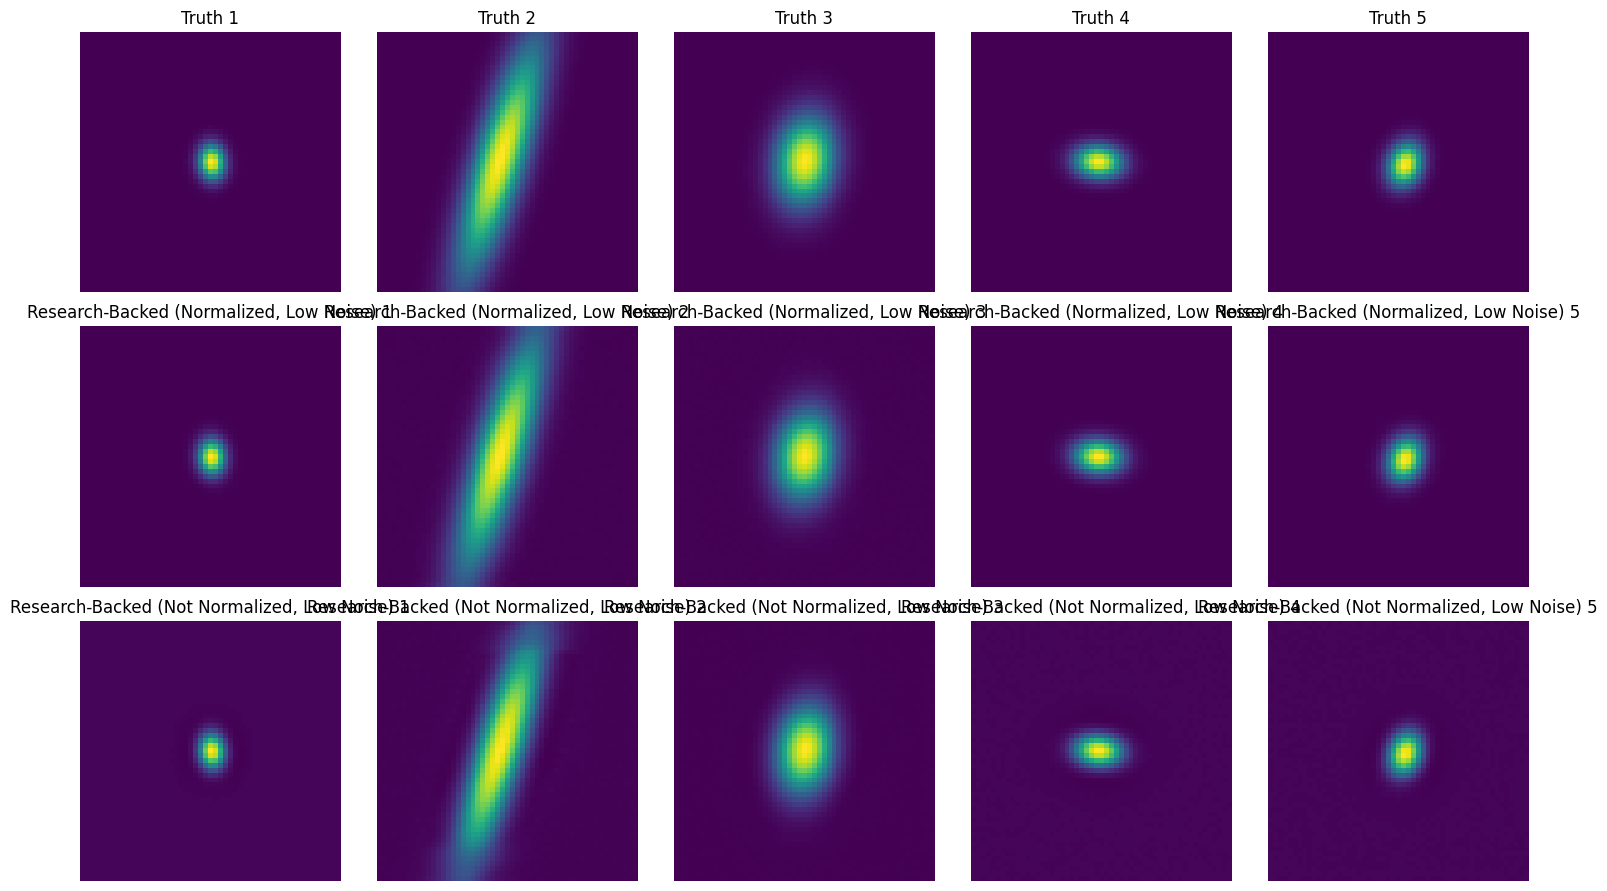

---


In [8]:
with experiment_section("Deconvolution Comparison Plots"):
    if not all_results:
        log_print("No results available for plotting.")
    else:
        # Get a representative sample for comparison
        num_samples = 5
        
        # Collect predictions and targets from all methods
        predictions_dict = {}
        target_images = None
        
        for method_name, result in all_results.items():
            predictions_dict[method_name] = result['predictions'][:num_samples]
            if target_images is None:
                target_images = result['target_images'][:num_samples]
        
        # Ensure consistent shapes
        if target_images.ndim == 4:
            target_images = target_images.squeeze(-1)
        
        for method_name in predictions_dict:
            if predictions_dict[method_name].ndim == 4:
                predictions_dict[method_name] = predictions_dict[method_name].squeeze(-1)
        
        # Create comparison plot
        n_methods = len(predictions_dict)
        fig, axes = plt.subplots(n_methods + 1, num_samples, figsize=(15, 3 * (n_methods + 1)))
        
        # First row: Ground truth
        for i in range(num_samples):
            axes[0, i].imshow(target_images[i], cmap='viridis')
            axes[0, i].set_title(f'Truth {i+1}')
            axes[0, i].axis('off')
        
        # Subsequent rows: Predictions from each method
        for row_idx, (method_name, preds) in enumerate(predictions_dict.items(), start=1):
            for i in range(num_samples):
                axes[row_idx, i].imshow(preds[i], cmap='viridis')
                axes[row_idx, i].set_title(f'{method_name} {i+1}')
                axes[row_idx, i].axis('off')
        
        plt.tight_layout()
        save_plot("deconvnet_comparison.png")
        plt.show()

## Spatial Residuals Heat Map

Spatial Residuals Analysis
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
Creating spatial residuals comparison for 2 methods
Computing spatial residuals for 5000 images across 2 methods...


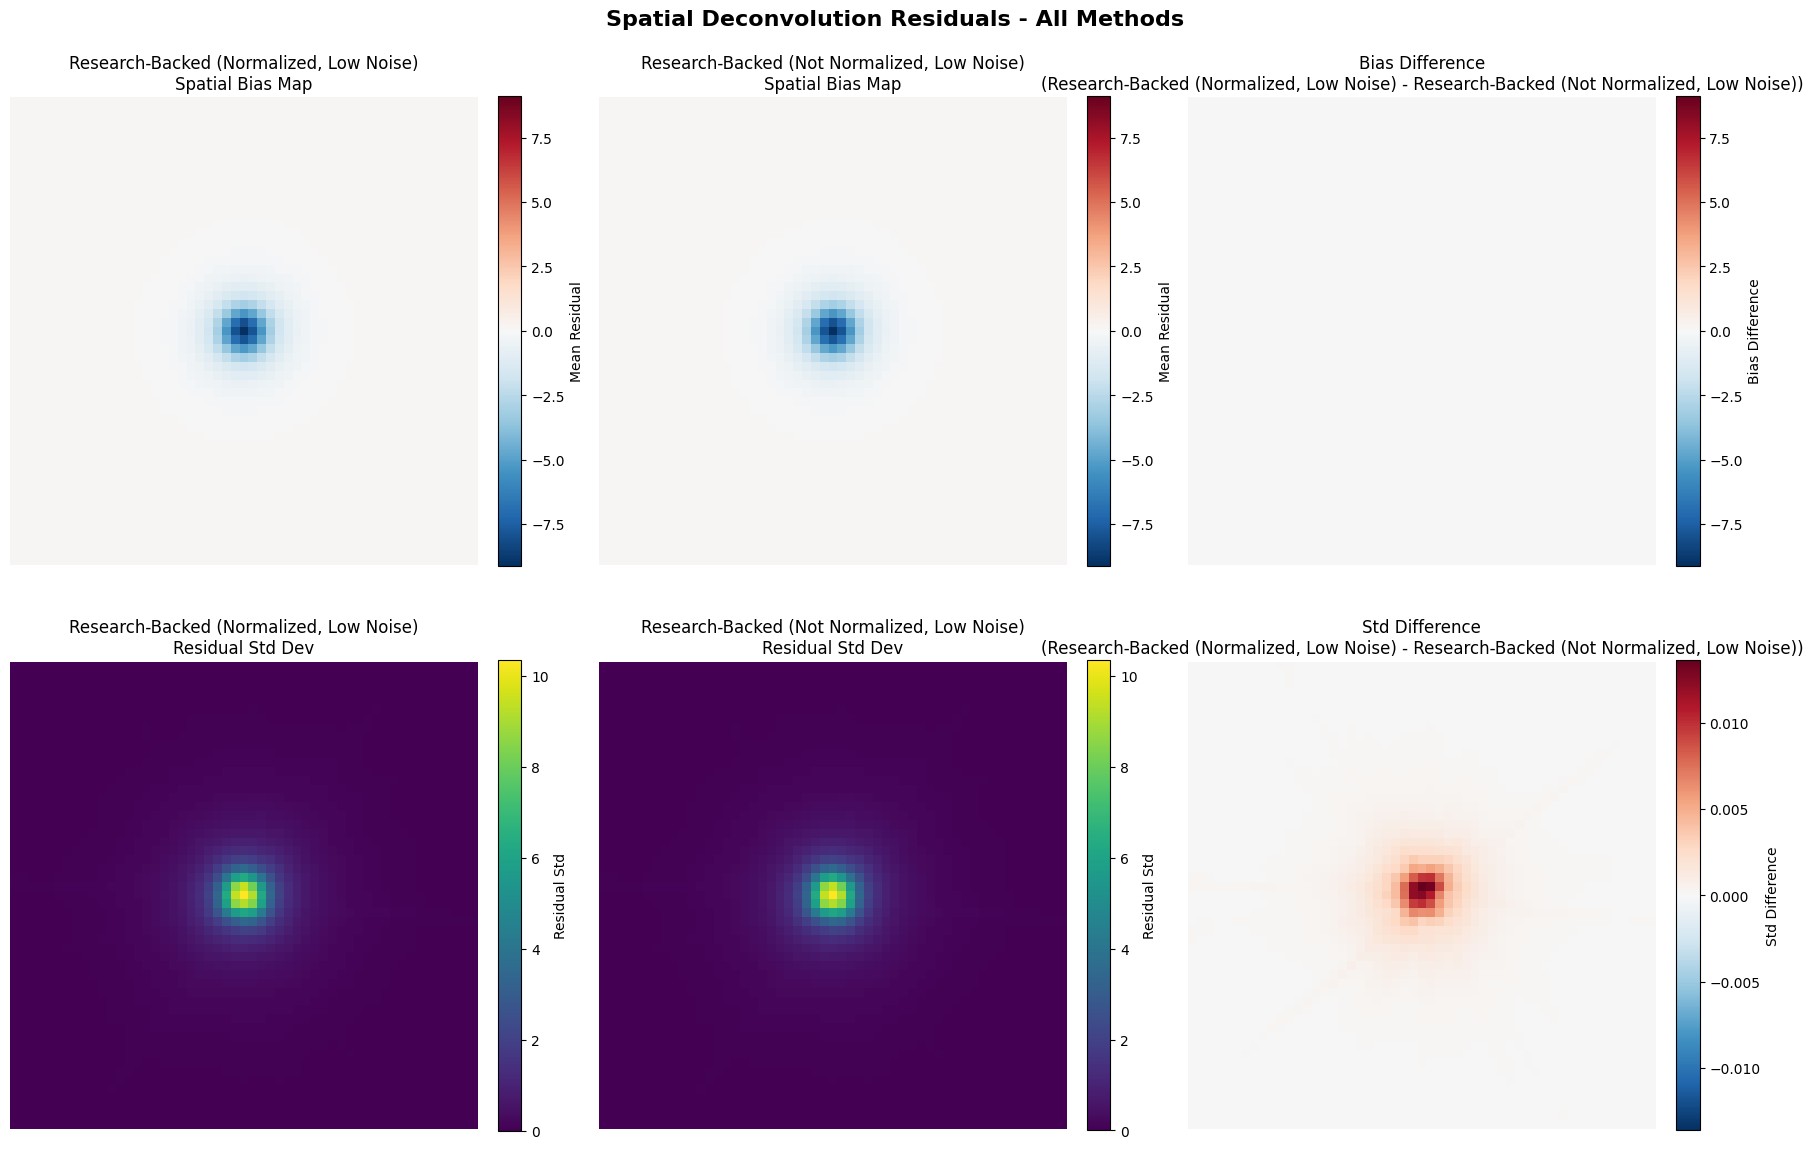

DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/deconvnet_spatial_residuals_20251005_230509.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/deconvnet_spatial_residuals_20251005_230509.png (size: 15128 bytes)
![deconvnet_spatial_residuals_20251005_230509.png](deconvnet_spatial_residuals_20251005_230509.png)


<Figure size 640x480 with 0 Axes>

---


In [9]:
with experiment_section("Spatial Residuals Analysis"):
    if not all_results:
        log_print("No results available for spatial residuals.")
    else:
        # Collect all predictions and ensure consistent target images
        predictions_dict = {}
        target_images = None
        
        for method_name, result in all_results.items():
            predictions_dict[method_name] = result['predictions']
            if target_images is None:
                target_images = result['target_images']
        
        log_print(f"Creating spatial residuals comparison for {len(predictions_dict)} methods")
        
        # Create spatial residuals plot with flexible layout
        from shearnet.deconvnet.utils.plot_helpers import plot_spatial_residuals
        
        plot_spatial_residuals(
            target_images=target_images,
            predictions_dict=predictions_dict,
            path=None,
            title="Spatial Deconvolution Residuals - All Methods"
        )
        
        plt.tight_layout()
        save_plot("deconvnet_spatial_residuals.png")
        plt.show()